    Import all the required packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import ensemble
from sklearn import cross_validation
import time
from sklearn.metrics import roc_auc_score as auc
import seaborn as sns

C:\Users\pothulbh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
#xls = pd.ExcelFile('collections.xlsx')
df1 = pd.read_excel(xls, 'Loan_Status_MartoMay')
df2 = pd.read_excel(xls, 'Loan_Status_AprtoJun')

    Agents KPIs 

In [4]:
calls = pd.read_excel(xls, 'DD')

In [627]:
calls1 = calls.drop('Avg_attempts',axis=1)

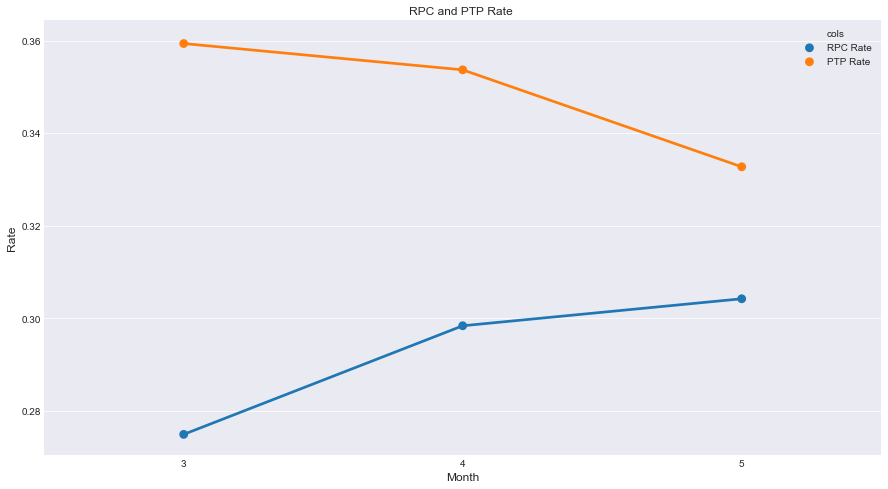

In [649]:

df = calls1.melt('Month', var_name='cols',  value_name='vals')
#sns.factorplot(x="Month", y="vals", hue='cols', data=df)
plt.figure(figsize=(15,8))
sns.pointplot(x="Month", y="vals", hue='cols', data=df)
plt.title('RPC and PTP Rate ')
plt.ylabel('Rate', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

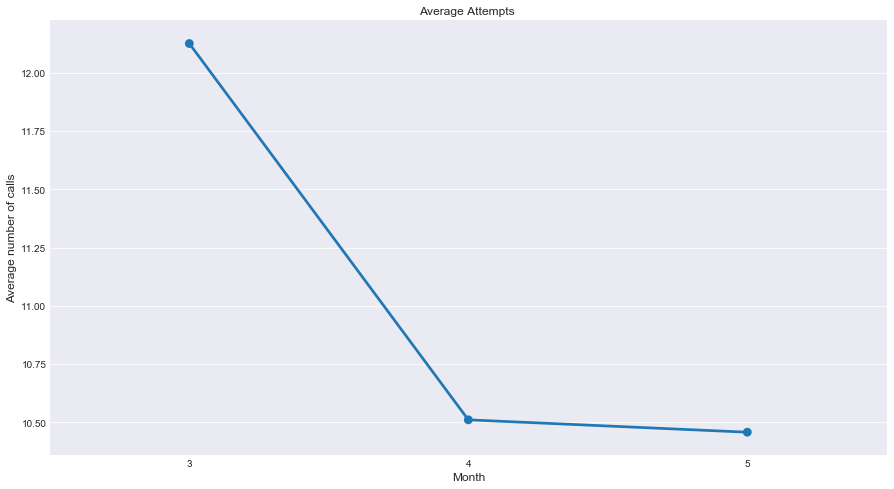

In [651]:
plt.figure(figsize=(15,8))
sns.pointplot(x="Month", y='Avg_attempts', data=calls)
plt.title('Average Attempts ')
plt.ylabel('Average number of calls', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

    Combined data from March to June

In [8]:
a = pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)

In [9]:
#seperate data for months
March = a.loc[a['Month'] == 'March']
April = a.loc[a['Month'] == 'April']
May = a.loc[a['Month'] == 'May']
June = a.loc[a['Month'] == 'June']

    Drop duplicates accounts in Months

In [165]:
April = April.drop_duplicates(subset='Loan_id', keep="last")
May = May.drop_duplicates(subset='Loan_id', keep="last")

33636


    Extract the data for Regular accounts for April, May and June

In [168]:
AprilTB = April.loc[April['Bucket'] != 'REGULAR']
MayTB = May.loc[May['Bucket'] != 'REGULAR']
JuneTB = June.loc[June['Bucket'] != 'REGULAR']

In [169]:
print(len(JuneTB))
print(len(MayTB))
print(len(AprilTB))
len(March)

2030
11178
11161


24575

    Account move-forward rate for March, April and May

In [170]:
#Move-forward for March
u_loans = AprilTB.Loan_id.unique()
rf = len(March.loc[March['Loan_id'].isin(u_loans)])
rf_percent = rf/len(March);rf_percent

0.08545269582909461

In [171]:
#Move-forward for April
um_loans = MayTB.Loan_id.unique()
rf = len(April.loc[April['Loan_id'].isin(um_loans)])
rf_percent = rf/len(April);rf_percent

0.1330419788322036

In [172]:
#Move-forward for May
uj_loans = JuneTB.Loan_id.unique()
rf = len(May.loc[May['Loan_id'].isin(uj_loans)])
rf_percent = rf/len(May);rf_percent

0.0561673399369155

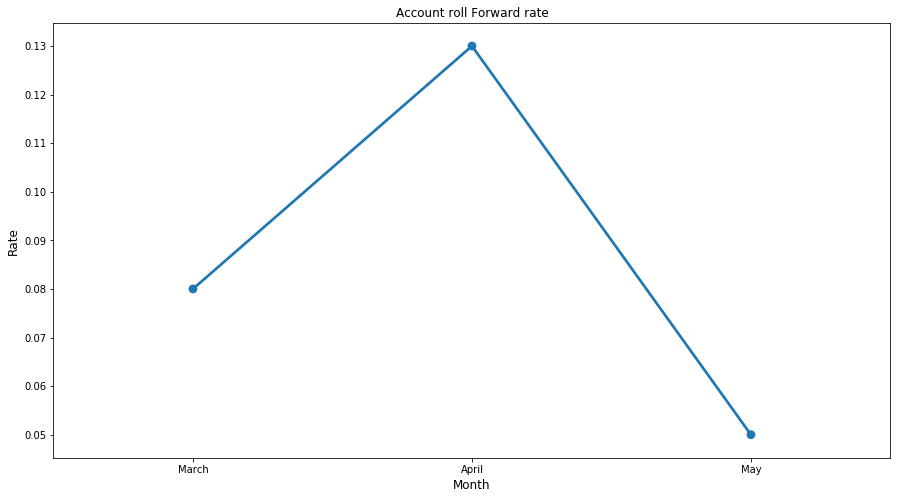

In [175]:
plt.figure(figsize=(15,8))
sns.pointplot(x=['March','April','May'], y=[0.08,0.13,0.05])
plt.title('Account roll Forward rate')
plt.ylabel('Rate', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

    Account move-forward rate for March, April and May

In [176]:
#sum of march outstanding balance
print(sum(March.PRINBALANCE))
#all the loans in April that are in March, calculate sum of outstanding balance
mar_loans = March.Loan_id.unique()
rf = April.loc[April['Loan_id'].isin(mar_loans)]
print(sum(rf.PRINBALANCE))


cf_rate = (sum(rf.PRINBALANCE))/sum(March.PRINBALANCE);cf_rate

827728346975.54
782316250231.0394


0.9451364727202672

In [178]:
#sum of April outstanding balance
print(sum(April.PRINBALANCE))
#all the loans in May that are in april, cal sum of outstanding balance
apr_loans = April.Loan_id.unique()
rf = May.loc[May['Loan_id'].isin(apr_loans)]
print(sum(rf.PRINBALANCE))

cf_rate = (sum(rf.PRINBALANCE))/sum(April.PRINBALANCE);cf_rate

1100552078718.421
936289470484.4395


0.850745265571382

In [179]:
#sum of May outstanding balance
print(sum(May.PRINBALANCE))
#all the loans in June that are in May, cal sum of outstanding balance
may_loans = May.Loan_id.unique()
rf = June.loc[June['Loan_id'].isin(may_loans)]
print(sum(rf.PRINBALANCE))

cf_rate = (sum(rf.PRINBALANCE))/sum(May.PRINBALANCE);cf_rate

1192646996663.7107
940858065452.7798


0.7888822661564732

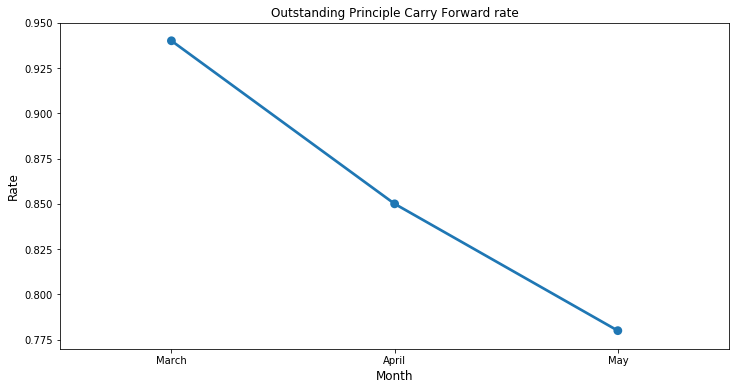

In [180]:
plt.figure(figsize=(12,6))
sns.pointplot(x=['March','April','May'], y=[0.94,0.85,0.78])
plt.title('Outstanding Principle Carry Forward rate')
plt.ylabel('Rate', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

### Carry forward for each loan (Optional)

In [18]:
mar_cf = pd.merge(March, April, on='Loan_id')

In [19]:
mar_cf = mar_cf.drop(['Bucket_y', 'TENURE_y', 'Months on Books_y', 'Sanctioned Amount_y', 'Month_y'],axis=1)
mar_cf['roll_forward'] = mar_cf.PRINBALANCE_x - mar_cf.PRINBALANCE_y
mar_cf.head()

,Loan_id,Bucket_x,TENURE_x,PRINBALANCE_x,Months on Books_x,Sanctioned Amount_x,Month_x,PRINBALANCE_y,roll_forward
0,A205346000,TB0,36,3693500.0,33,22000000,March,1332100.0,2361400.0
1,A675851816,TB0,48,24353700.0,30,40000000,March,20875500.0,3478200.0
2,A260852240,TB0,48,42514900.0,24,60000000,March,37947922.5,4566977.5
3,A374402177,TB0,36,12290300.0,19,20000000,March,11214900.0,1075400.0
4,A211889361,TB0,36,9396700.0,25,22000000,March,8666200.0,730500.0


In [20]:
apr_cf = pd.merge(April, May, on='Loan_id')

In [21]:
apr_cf = apr_cf.drop(['Bucket_y', 'TENURE_y', 'Months on Books_y', 'Sanctioned Amount_y', 'Month_y'],axis=1)
apr_cf['roll_forward'] = apr_cf.PRINBALANCE_x - apr_cf.PRINBALANCE_y
apr_cf.head()

,Loan_id,Bucket_x,TENURE_x,PRINBALANCE_x,Months on Books_x,Sanctioned Amount_x,Month_x,PRINBALANCE_y,roll_forward
0,A810487695,TB0,48,10539100.0,37,30000000,April,9649000.0,890100.0
1,A948976866,TB0,36,20002300.0,19,30000000,April,15937400.0,4064900.0
2,A527783393,TB0,48,1393300.0,47,40000000,April,4200.0,1389100.0
3,A898556366,TB0,48,64239700.0,31,119000000,April,52357200.0,11882500.0
4,A827968956,TB0,36,10207500.0,25,20000000,April,7912900.0,2294600.0


In [22]:
may_cf = pd.merge(May,June, on='Loan_id')

In [23]:
may_cf = may_cf.drop(['Bucket_y', 'TENURE_y', 'Months on Books_y', 'Sanctioned Amount_y', 'Month_y'],axis=1)
may_cf['roll_forward'] = may_cf.PRINBALANCE_x - may_cf.PRINBALANCE_y
may_cf.head()

,Loan_id,Bucket_x,TENURE_x,PRINBALANCE_x,Months on Books_x,Sanctioned Amount_x,Month_x,PRINBALANCE_y,roll_forward
0,A810487695,TB0,48,9649000.0,38,30000000,May,9648700.0,300.0
1,A269873383,TB0,36,4441700.0,30,20000000,May,2885800.0,1555900.0
2,A587221730,TB0,36,2562700.0,33,20000000,May,2562200.0,500.0
3,A541512346,TB0,36,2757700.0,32,24000000,May,633300.0,2124400.0
4,A592076570,TB0,36,4702100.0,32,20000000,May,469500.0,4232600.0


    Optional analysis ends.

In [181]:
df3 = pd.read_excel(xls, 'Call Details')
df3.head()

,month,Application_Id,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts
0,3,MX-100062359,AGNT50,1,1,1
1,3,MX-100095892,AGNT12,1,0,2
2,3,MX-100116696,AGNT36,2,0,3
3,3,MX-10011780,AGNT39,2,1,10
4,3,MX-100133826,AGNT48,4,3,17


In [601]:
#Average number of call made every month
df3.groupby('month')['total_contacts'].mean()

month
3    12.125772
4    10.511025
5    10.457885
Name: total_contacts, dtype: float64

In [26]:
df3.groupby('month')['Right_Party_Contact'].sum()/df3.groupby('month')['total_contacts'].sum()

month
3    0.274953
4    0.298409
5    0.304238
dtype: float64

In [131]:
#PTP rate of a month =  sum of ptp / number of right calls made

In [27]:
df3.groupby('month')['Promise_to_pay'].sum()/df3.groupby('month')['Right_Party_Contact'].sum()

month
3    0.359362
4    0.353683
5    0.332742
dtype: float64

    ----------XX--------------

    Data Validity: Outliers
    Data Completeness: Msising Value
    Data Uniqueness: Duplicates in categories/loan ids
    Redundant variables: completeness of data
    Correlated variables
    stored Data format over different tables

In [182]:
df4 = pd.read_excel(xls, 'Loan Details')
df4.head()

,Loan_id,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount
0,A100005454,0.177021,7334734.0,36,30000000
1,A100026967,0.248750,6000000.0,48,38000000
2,A100040113,0.455961,11216760.0,48,105000000
3,A100080302,0.232607,5529077.0,48,33000000
4,A100104482,0.537601,15000000.0,48,120000000


    Data Completeness: Missing Value

In [183]:
df4.isna().sum()

Loan_id                 0
Debt_to_burden_Ratio    0
total_income            0
TENURE                  0
Sanctioned Amount       0
dtype: int64

    Data Uniqueness: Duplicates in categories/loan ids

In [22]:
len(df4.Loan_id.unique())/len(df4)

1.0

    Data Validity: Outliers

In [25]:
df4 = df4[np.abs(df4.total_income-df4.total_income.mean()) <= (3*df4.total_income.std())]
df4 = df4[np.abs(df4.Debt_to_burden_Ratio-df4.Debt_to_burden_Ratio.mean()) <= (3*df4.Debt_to_burden_Ratio.std())]
df4 = df4[np.abs(df4['Sanctioned Amount']-df4['Sanctioned Amount'].mean()) <= (3*df4['Sanctioned Amount'].std())]
df4 = df4[np.abs(df4.TENURE-df4.TENURE.mean()) <= (3*df4.TENURE.std())]


    Data Uniqueness:Test if any class is under-represented/over-represented because of case sensitivity issues

In [27]:
len(df4['Loan_id'].str.lower())/len(df4)

1.0

    ---------XX--------

In [320]:
df3.head()

,month,Application_Id,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts
0,3,MX-100062359,AGNT50,1,1,1
1,3,MX-100095892,AGNT12,1,0,2
2,3,MX-100116696,AGNT36,2,0,3
3,3,MX-10011780,AGNT39,2,1,10
4,3,MX-100133826,AGNT48,4,3,17


    Group the data to agents level, to measure their performance

In [34]:
agentsg = df3.groupby(['month','Login_ID'])['Right_Party_Contact','Promise_to_pay','total_contacts'].sum().reset_index()

In [36]:
agents = df3.groupby(['Login_ID'])['Right_Party_Contact','Promise_to_pay','total_contacts'].sum().reset_index()

In [37]:
agents['rpc_rate'] = agents['Right_Party_Contact']/agents['total_contacts']
agents['ptp_rate'] = agents['Promise_to_pay']/agents['Right_Party_Contact']
agents['self_calls_index'] = agents['total_contacts']/agents['total_contacts'].median()

In [38]:
agents.head()

,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts,rpc_rate,ptp_rate,self_calls_index
0,AGNT1,3385,1300,16198,0.208976,0.384047,8.062718
1,AGNT10,4078,1495,16883,0.241545,0.366601,8.403683
2,AGNT100,58,1,59,0.983051,0.017241,0.029368
3,AGNT101,27,10,48,0.562500,0.370370,0.023892
4,AGNT102,1,0,1,1.000000,0.000000,0.000498


    Median of calls answered is 2000, while there are few agents with calls less than 100. 
    Segment agents by the number of calls answered < 500 and > 500, perform analysis for both groups seperately

In [39]:
agents = agents.loc[agents['total_contacts'] > 10]

In [40]:
n_agents = agents.loc[(agents['total_contacts'] <= 500)]
o_agents = agents.loc[agents['total_contacts'] > 500]

In [41]:
n_agents.sort_values(['rpc_rate']).head()

,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts,rpc_rate,ptp_rate,self_calls_index
54,AGNT45,18,11,53,0.339623,0.611111,0.026381
102,AGNT89,36,18,100,0.360000,0.500000,0.049776
82,AGNT70,35,11,92,0.380435,0.314286,0.045794
84,AGNT72,56,25,146,0.383562,0.446429,0.072673
73,AGNT62,45,10,114,0.394737,0.222222,0.056745


In [44]:
n_agents.sort_values(['rpc_rate']).tail()

,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts,rpc_rate,ptp_rate,self_calls_index
85,AGNT73,102,2,106,0.962264,0.019608,0.052763
62,AGNT52,164,22,170,0.964706,0.134146,0.084619
2,AGNT100,58,1,59,0.983051,0.017241,0.029368
79,AGNT68,81,0,81,1.000000,0.000000,0.040319
6,AGNT104,12,0,12,1.000000,0.000000,0.005973


In [45]:
o_agents.sort_values(['rpc_rate']).head()

,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts,rpc_rate,ptp_rate,self_calls_index
16,AGNT113,307,137,2372,0.129427,0.446254,1.180687
112,AGNT98,1758,805,11285,0.155782,0.457907,5.617222
45,AGNT37,2922,906,17882,0.163405,0.310062,8.900946
63,AGNT53,3202,1436,18232,0.175625,0.448470,9.075162
47,AGNT39,3201,1247,17592,0.181958,0.389566,8.756595


In [44]:
o_agents.sort_values(['rpc_rate']).tail()

,Login_ID,Right_Party_Contact,Promise_to_pay,total_contacts,rpc_rate,ptp_rate,self_calls_index
43,AGNT35,13855,2511,17959,0.771479,0.181234,8.939273
26,AGNT2,13195,1775,16363,0.806392,0.134521,8.144848
15,AGNT112,3384,166,3767,0.898328,0.049054,1.875062
103,AGNT9,16313,1888,16906,0.964924,0.115736,8.415132
14,AGNT111,4181,31,4320,0.967824,0.007414,2.150324


     agent performance analysis(Optional Analysis)

In [38]:
df5 = pd.read_excel(xls, 'Loan_ID mapping')

In [187]:
j1 =pd.merge(df3,df5,how='left', left_on=['Application_Id'], right_on = ['Application_id'])
j1 = j1.drop(['Application_Id','Application_id'],axis=1)

In [330]:
#Rate of reduction in the PRINBALANCE

In [188]:
j1_mar = pd.merge(March,j1.loc[j1['month'] == 3],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

In [189]:
q21 = pd.DataFrame(j1_mar.groupby('Login_ID')['PRINBALANCE'].sum()).reset_index()

In [190]:
j1_apr = pd.merge(April,j1.loc[j1['month'] == 4],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

In [191]:
q22 = pd.DataFrame(j1_apr.groupby('Login_ID')['PRINBALANCE'].sum()).reset_index()

In [192]:
j1_may = pd.merge(May,j1.loc[j1['month'] == 5],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

In [193]:
q23 = pd.DataFrame(j1_may.groupby('Login_ID')['PRINBALANCE'].sum()).reset_index()

In [56]:
agent_per = pd.merge(pd.merge(q21, q22, on = 'Login_ID'),q23, on = 'Login_ID')

In [57]:
agent_per.head(10)

,Login_ID,PRINBALANCE_x,PRINBALANCE_y,PRINBALANCE
0,AGNT1,1.749179e+10,3.030069e+10,3.044419e+10
1,AGNT10,1.458839e+10,2.617473e+10,2.769501e+10
2,AGNT11,1.606512e+10,2.703495e+10,2.880380e+10
3,AGNT114,6.268698e+09,1.591849e+10,5.874495e+09
4,AGNT12,1.716991e+10,3.751949e+10,3.462498e+10
5,AGNT14,1.569938e+10,2.768568e+10,2.931908e+10
6,AGNT15,6.914152e+09,2.671540e+10,3.039527e+10
7,AGNT16,1.560612e+10,5.913800e+06,3.796440e+07
8,AGNT17,1.807461e+10,3.544039e+10,1.516259e+08
9,AGNT18,2.148175e+10,3.804935e+10,3.350198e+10


In [58]:
agent_per['reduction'] = ((agent_per['PRINBALANCE']-agent_per['PRINBALANCE_x'])/agent_per['PRINBALANCE_x'])*100

    Optional agent prformance analysis ends

    Term Completed Vs Principle outstanding balance

In [196]:
March['Term Completed']= March['Months on Books']/March['TENURE']
March['PRIN Completed']= March['PRINBALANCE']/March['Sanctioned Amount']
March.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
1,A205346000,TB0,36,3693500.0,33,22000000,March,0.916667,0.167886,True
2,A675851816,TB0,48,24353700.0,30,40000000,March,0.625000,0.608842,True
7,A260852240,TB0,48,42514900.0,24,60000000,March,0.500000,0.708582,True
19,A374402177,TB0,36,12290300.0,19,20000000,March,0.527778,0.614515,True
21,A211889361,TB0,36,9396700.0,25,22000000,March,0.694444,0.427123,True


In [197]:
April['Term Completed']= April['Months on Books']/April['TENURE']
April['PRIN Completed']= April['PRINBALANCE']/April['Sanctioned Amount']
April.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
0,A810487695,TB0,48,10539100.0,37,30000000,April,0.770833,0.351303,True
5,A948976866,TB0,36,20002300.0,19,30000000,April,0.527778,0.666743,False
6,A527783393,TB0,48,1393300.0,47,40000000,April,0.979167,0.034833,False
8,A898556366,TB0,48,64239700.0,31,119000000,April,0.645833,0.539829,True
10,A827968956,TB0,36,10207500.0,25,20000000,April,0.694444,0.510375,True


In [198]:
May['Term Completed']= May['Months on Books']/May['TENURE']
May['PRIN Completed']= May['PRINBALANCE']/May['Sanctioned Amount']
May.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
3,A810487695,TB0,48,9649000.0,38,30000000,May,0.791667,0.321633,True
4,A269873383,TB0,36,4441700.0,30,20000000,May,0.833333,0.222085,False
9,A587221730,TB0,36,2562700.0,33,20000000,May,0.916667,0.128135,True
12,A541512346,TB0,36,2757700.0,32,24000000,May,0.888889,0.114904,False
13,A592076570,TB0,36,4702100.0,32,20000000,May,0.888889,0.235105,False


In [199]:
final = pd.concat([March,April,May])

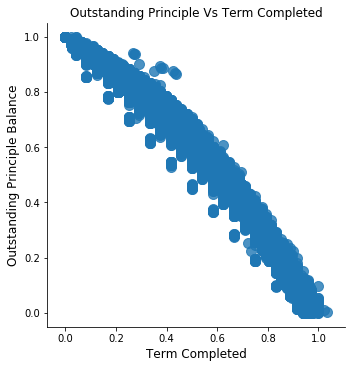

In [304]:
import seaborn as sns
sns.lmplot('Term Completed', # Horizontal axis
           'PRIN Completed', # Vertical axis
           data=final, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

plt.title('Outstanding Principle Vs Term Completed')
plt.ylabel('Outstanding Principle Balance', fontsize=12)
plt.xlabel('Term Completed', fontsize=12)
plt.show()

In [63]:
df4.head()

,Loan_id,Debt_to_burden_Ratio,total_income,TENURE,Sanctioned Amount
0,A100005454,0.177021,7334734.0,36,30000000
1,A100026967,0.248750,6000000.0,48,38000000
2,A100040113,0.455961,11216760.0,48,105000000
3,A100080302,0.232607,5529077.0,48,33000000
4,A100104482,0.537601,15000000.0,48,120000000


In [203]:
AprilTB.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
0,A810487695,TB0,48,10539100.0,37,30000000,April,0.770833,0.351303,True
5,A948976866,TB0,36,20002300.0,19,30000000,April,0.527778,0.666743,False
6,A527783393,TB0,48,1393300.0,47,40000000,April,0.979167,0.034833,False
8,A898556366,TB0,48,64239700.0,31,119000000,April,0.645833,0.539829,True
10,A827968956,TB0,36,10207500.0,25,20000000,April,0.694444,0.510375,True


In [204]:
u_loans = AprilTB.Loan_id.unique()
df4['mar_rf'] = df4['Loan_id'].isin(u_loans)

In [205]:
u_loans = MayTB.Loan_id.unique()
df4['apr_rf'] = df4['Loan_id'].isin(u_loans)

In [206]:
u_loans = JuneTB.Loan_id.unique()
df4['may_rf'] = df4['Loan_id'].isin(u_loans)

    New Feature to indicate loan accounts peformance on paying debt: Princile completed/Tenure completed

        Final dataset is a collection of loan_account, its past 3 months history, Average Intensity made to that account, RTC rate, PTP rate

In [207]:
u_loans = AprilTB.Loan_id.unique()
March['roll_f'] = March['Loan_id'].isin(u_loans)
March.head(2)

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
1,A205346000,TB0,36,3693500.0,33,22000000,March,0.916667,0.167886,True
2,A675851816,TB0,48,24353700.0,30,40000000,March,0.625000,0.608842,True


In [208]:
u_loans = MayTB.Loan_id.unique()
April['roll_f'] = April['Loan_id'].isin(u_loans)
April.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
0,A810487695,TB0,48,10539100.0,37,30000000,April,0.770833,0.351303,True
5,A948976866,TB0,36,20002300.0,19,30000000,April,0.527778,0.666743,False
6,A527783393,TB0,48,1393300.0,47,40000000,April,0.979167,0.034833,False
8,A898556366,TB0,48,64239700.0,31,119000000,April,0.645833,0.539829,True
10,A827968956,TB0,36,10207500.0,25,20000000,April,0.694444,0.510375,True


In [209]:
u_loans = JuneTB.Loan_id.unique()
May['roll_f'] = May['Loan_id'].isin(u_loans)
May.head()

,Loan_id,Bucket,TENURE,PRINBALANCE,Months on Books,Sanctioned Amount,Month,Term Completed,PRIN Completed,roll_f
3,A810487695,TB0,48,9649000.0,38,30000000,May,0.791667,0.321633,True
4,A269873383,TB0,36,4441700.0,30,20000000,May,0.833333,0.222085,False
9,A587221730,TB0,36,2562700.0,33,20000000,May,0.916667,0.128135,True
12,A541512346,TB0,36,2757700.0,32,24000000,May,0.888889,0.114904,False
13,A592076570,TB0,36,4702100.0,32,20000000,May,0.888889,0.235105,False


In [48]:
ln_mo_cl.head(1)

,month,Loanid,Right_Party_Contact,Promise_to_pay,total_contacts
0,April,A100005454,1,1,1


    join call details to the data

In [210]:
import calendar
j1['month'] = j1['month'].apply(lambda x: calendar.month_name[x])

In [240]:
ln_mo_cl = j1.groupby(['month','Loanid'])['Right_Party_Contact','Promise_to_pay','total_contacts'].sum().reset_index()

In [241]:
f_calls_mar = pd.merge(March,ln_mo_cl.loc[ln_mo_cl['month'] == 'March'],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

In [242]:
f_calls_apr = pd.merge(April,ln_mo_cl.loc[ln_mo_cl['month'] == 'April'],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

In [243]:
f_calls_may = pd.merge(May,ln_mo_cl.loc[ln_mo_cl['month'] == 'May'],how='left', left_on=['Loan_id'], right_on = ['Loanid'])

    join historical performance details to the data 

In [215]:
history = pd.read_excel(xls, 'Historical 6 Months Details')

In [216]:
history.head(1)

,Loan_id,paidcure,paiduncure,unpaid,rollb,rollf,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max6del,max3del,Month
0,A810487695,2,1,3,1,0,5,2,4,2,5,5,April


In [217]:
f_march = pd.merge(f_calls_mar,history.loc[history['Month'] == 'March'],how='left', left_on=['Loan_id'], right_on = ['Loan_id'])

In [218]:
f_april = pd.merge(f_calls_apr,history.loc[history['Month'] == 'April'],how='left', left_on=['Loan_id'], right_on = ['Loan_id'])

In [219]:
f_may = pd.merge(f_calls_may,history.loc[history['Month'] == 'May'],how='left', left_on=['Loan_id'], right_on = ['Loan_id'])

In [244]:
ln_mo_cl['month'].value_counts()

May      26693
April    25090
March    23142
Name: month, dtype: int64

    Before modeling, clean the data as per below steps
        Remove miss values.
        Remove dups 'month', 'Loanid', 'rollf','Month_y' -done
        True or False to 1 or 0 -done
        Correlation

In [245]:
f_mod = pd.concat([f_march,f_april,f_may]).dropna()

In [246]:
f_mod['roll_forward']  = np.where(f_mod['roll_f'] == True, 1, 0)

In [247]:
f_mod = f_mod.drop(['roll_f', 'month', 'Loanid','rollf','Month_y'],axis=1)

In [249]:
df4_mod = df4.drop(['Sanctioned Amount','mar_rf','apr_rf','may_rf'],axis=1)

In [250]:
f_mod = pd.merge(f_mod,df4_mod,how='left', left_on=['Loan_id'], right_on = ['Loan_id'])

In [251]:
f_mod = f_mod[np.abs(f_mod.Debt_to_burden_Ratio-f_mod.Debt_to_burden_Ratio.mean()) <= (3*f_mod.Debt_to_burden_Ratio.std())]

In [252]:
f_mod = f_mod[np.abs(f_mod.total_income-f_mod.total_income.mean()) <= (3*f_mod.total_income.std())]

In [253]:
f_mod['price_to_tenure'] = f_mod['PRIN Completed']/f_mod['Term Completed']

In [255]:
f_mod = f_mod.replace([np.inf, -np.inf], np.nan)
f_mod = f_mod.dropna()

In [257]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = f_mod.select_dtypes(include=numerics)

In [258]:
numeric = numeric.drop(['TENURE_x','TENURE_y'],axis=1)

In [305]:
y = f_mod['roll_forward']
#X = f_mod[['Term Completed', 'PRIN Completed', 'Promise_to_pay', 'total_contacts', 'paidcure', 'paiduncure', 'unpaid', 'rollb', 'num3mosdel', 'num3mosdel_2plus']]
X = f_mod.drop(['Loan_id','roll_forward','Month_x','Bucket','TENURE_x','TENURE_y','Months on Books','PRINBALANCE','Term Completed','unpaid','PRIN Completed','total_income','Sanctioned Amount','max6del','num6mosdel','num3mosdel'], axis=1)

    The below plor is after removing many correlated variables

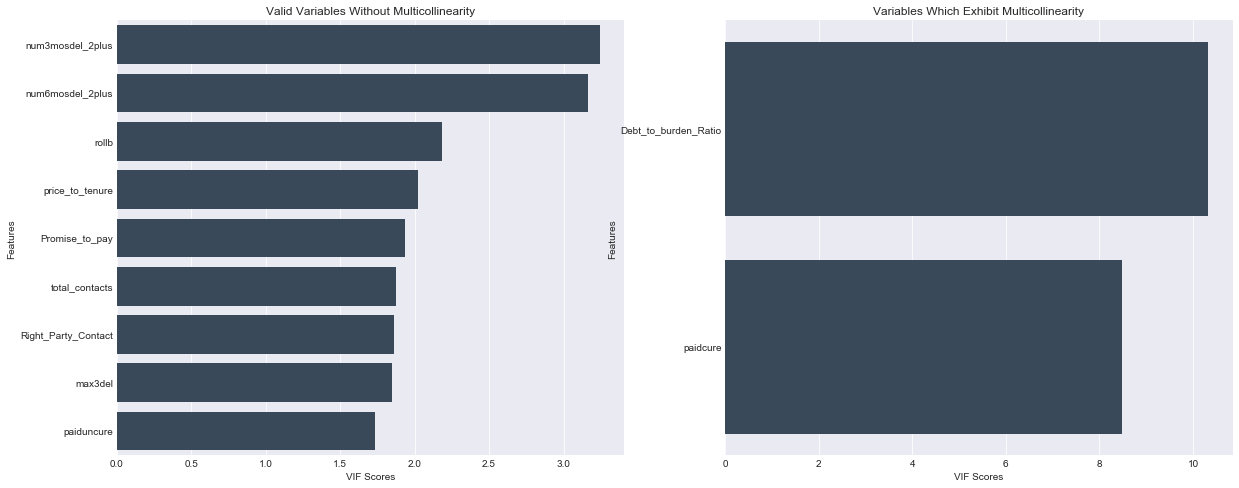

In [333]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


Filterd = X.fillna(0)
vifDict = calculate_vif_(Filterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#34495e")
sns.barplot(data=variablesWithMC,x="vifScore",y="variables",ax=ax2,orient="h",color="#34495e")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

plt.show()

    Predictive power of variable by is AUC score

In [324]:
#separate the features and target column
trainLabels = f_mod['roll_forward']
trainFeatures = f_mod.drop(['Loan_id','roll_forward','Month_x','Bucket','num6mosdel','num6mosdel_2plus','num3mosdel_2plus'], axis=1)

In [325]:
#Use a Gradient Boosting classifier to estimate each feature predictive power (using AUC metric)
verySimpleLearner = ensemble.GradientBoostingClassifier(n_estimators=10, max_features=1, max_depth=3,
                                                        min_samples_leaf=100,learning_rate=0.3, subsample=0.65,
                                                        loss='deviance', random_state=1)

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels, test_size=0.5, random_state=1)
        
startTime = time.time()
singleFeatureAUC_list = []
singleFeatureAUC_dict = {}
for feature in X_train.columns:
    trainInputFeature = X_train[feature].values.reshape(-1,1)
    validInputFeature = X_valid[feature].values.reshape(-1,1)
    verySimpleLearner.fit(trainInputFeature, y_train)
    
    trainAUC = auc(y_train, verySimpleLearner.predict_proba(trainInputFeature)[:,1])
    validAUC = auc(y_valid, verySimpleLearner.predict_proba(validInputFeature)[:,1])
        
    singleFeatureAUC_list.append(validAUC)
    singleFeatureAUC_dict[feature] = validAUC
        
validAUC = np.array(singleFeatureAUC_list)
timeToTrain = (time.time()-startTime)/60
print("(min,mean,max) AUC = (%.3f,%.3f,%.3f). took %.2f minutes" %(validAUC.min(),validAUC.mean(),validAUC.max(), timeToTrain))

(min,mean,max) AUC = (0.527,0.603,0.710). took 0.04 minutes


In [326]:
#Single feature evaluation 
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(trainFeatures, trainLabels, 
                                                                       test_size=0.5, random_state=1)

verySimpleLearner = ensemble.GradientBoostingClassifier(n_estimators=20, max_features=1, max_depth=3, 
                                                        min_samples_leaf=100, learning_rate=0.1, 
                                                        subsample=0.65, loss='deviance', random_state=1)


startTime = time.time()
singleFeatureTable = pd.DataFrame(index=range(len(X_train.columns)), columns=['feature','AUC'])
for k,feature in enumerate(X_train.columns):
    trainInputFeature = X_train[feature].values.reshape(-1,1)
    validInputFeature = X_valid[feature].values.reshape(-1,1)
    verySimpleLearner.fit(trainInputFeature, y_train)
    
    validAUC = auc(y_valid, verySimpleLearner.predict_proba(validInputFeature)[:,1])
    singleFeatureTable.ix[k,'feature'] = feature
    singleFeatureTable.ix[k,'AUC'] = validAUC
        
print("finished evaluating single features. took %.2f minutes" %((time.time()-startTime)/60))

finished evaluating single features. took 0.07 minutes


In [327]:
#Sort the features according to AUC and present the table
singleFeatureTable = singleFeatureTable.sort_values(by='AUC', axis=0, ascending=False).reset_index(drop=True)

singleFeatureTable.ix[:15,:]

,feature,AUC
0,total_contacts,0.710967
1,max6del,0.664764
2,num3mosdel,0.656505
3,max3del,0.65186
4,Right_Party_Contact,0.638342
5,paidcure,0.628937
6,PRINBALANCE,0.618899
7,Term Completed,0.603282
8,price_to_tenure,0.59913
9,Promise_to_pay,0.594467


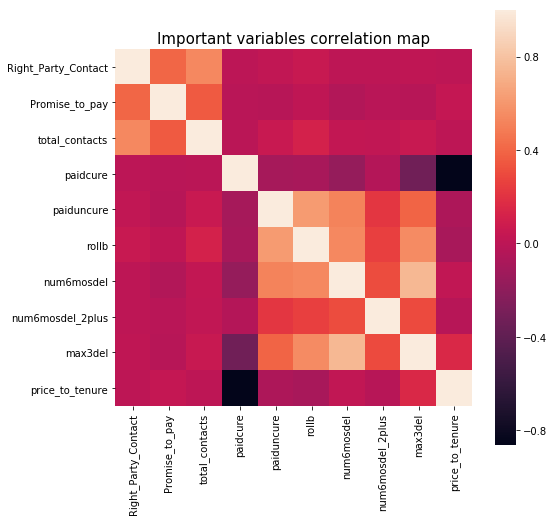

In [538]:
corrmat = X.corr(method='pearson')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [578]:
X.corr(method='pearson')

,Right_Party_Contact,Promise_to_pay,total_contacts,paidcure,paiduncure,rollb,num6mosdel,num3mosdel,num6mosdel_2plus,num3mosdel_2plus,max3del,price_to_tenure
Right_Party_Contact,1.000000,0.402407,0.538897,-0.003716,0.024776,0.052475,0.007451,0.000446,0.004107,0.002617,0.013171,0.010676
Promise_to_pay,0.402407,1.000000,0.354487,-0.014941,-0.022194,0.011333,-0.045425,-0.043863,-0.011690,-0.014386,-0.023367,0.037915
total_contacts,0.538897,0.354487,1.000000,-0.010041,0.061710,0.113974,0.027575,0.020746,0.018398,0.017436,0.047867,0.006957
paidcure,-0.003716,-0.014941,-0.010041,1.000000,-0.095509,-0.090958,-0.168861,-0.243879,-0.039622,-0.047739,-0.328957,-0.862017
paiduncure,0.024776,-0.022194,0.061710,-0.095509,1.000000,0.615240,0.516387,0.412902,0.221060,0.207724,0.393689,-0.066157
rollb,0.052475,0.011333,0.113974,-0.090958,0.615240,1.000000,0.536138,0.449029,0.252078,0.190194,0.554124,-0.090540
num6mosdel,0.007451,-0.045425,0.027575,-0.168861,0.516387,0.536138,1.000000,0.891638,0.302891,0.268233,0.750138,0.018238
num3mosdel,0.000446,-0.043863,0.020746,-0.243879,0.412902,0.449029,0.891638,1.000000,0.192736,0.219712,0.888925,0.086110
num6mosdel_2plus,0.004107,-0.011690,0.018398,-0.039622,0.221060,0.252078,0.302891,0.192736,1.000000,0.798219,0.300613,-0.023282
num3mosdel_2plus,0.002617,-0.014386,0.017436,-0.047739,0.207724,0.190194,0.268233,0.219712,0.798219,1.000000,0.341477,-0.019866


    Final Model has below variables:
        'Right_Party_Contact', 'Promise_to_pay', 'total_contacts', 'paidcure',
        'paiduncure', 'rollb', 'num6mosdel_2plus', 'num3mosdel_2plus',
        'max3del', 'Debt_to_burden_Ratio', 'price_to_tenure'

    1.Tha dataset is slightly imbalance so used AUC as performance metrci instead of Accuracy.
    2.For further improvement we can either undesample the majority class/ over sample te minority class/ do a combinationd -of over and under sampling
    3.To nullify the affect of unbalance data, change the threshold to 0.5 instead of 0.5

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=10, stratify=y)

In [307]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score,accuracy_score

In [312]:
#logistic regression
logis = LogisticRegression(class_weight = "balanced")
logis.fit(X_train, y_train)
print ("\n\n ---Logistic Model---")
logit_roc_auc = auc(y_test, np.where(logis.predict_proba(X_test)[:,1] > 0.4,1,0))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(y_test, np.where(logis.predict_proba(X_test)[:,1] > 0.4,1,0)))




 ---Logistic Model---
Logistic AUC = 0.79
             precision    recall  f1-score   support

          0       0.98      0.83      0.90     20381
          1       0.27      0.75      0.40      1671

avg / total       0.92      0.83      0.86     22052



In [315]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold,cross_val_predict

In [316]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,class_weight="balanced")
y_proba = cross_val_predict(rfc, X, y, cv=10, n_jobs=-1, method='predict_proba')
results = pd.DataFrame({'y': y, 'y_proba': y_proba[:,1]})
results = results.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
results.index = results.index + 1
results.index = results.index / len(results.index) * 100

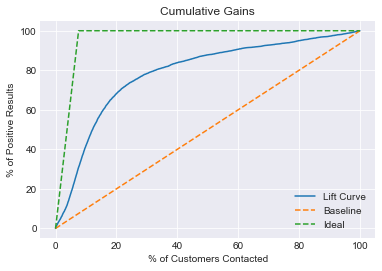

In [317]:
sns.set_style('darkgrid')
pred = results
pred['Lift Curve'] = pred.y.cumsum() / pred.y.sum() * 100
pred['Baseline'] = pred.index
base_rate = y.sum() / len(y) * 100
pred[['Lift Curve', 'Baseline']].plot(style=['-', '--', '--'])
pd.Series(data=[0, 100, 100], index=[0, base_rate, 100]).plot(style='--')
plt.title('Cumulative Gains')
plt.xlabel('% of Customers Contacted')
plt.ylabel("% of Positive Results")
plt.legend(['Lift Curve', 'Baseline', 'Ideal']);

In [269]:
from sklearn.ensemble import RandomForestClassifier

In [332]:
#random forest
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=8, 
    class_weight="balanced"
    #min_weight_fraction_leaf=0.02 
    )
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
acc = accuracy_score(y_test, np.where(logis.predict_proba(X_test)[:,1] > 0.40,1,0))
print ("Random Forest Accuracy = %2.2f" % acc)
print(classification_report(y_test, np.where(logis.predict_proba(X_test)[:,1] > 0.40,1,0)))




 ---Random Forest Model---
Random Forest Accuracy = 0.83
             precision    recall  f1-score   support

          0       0.98      0.83      0.90     20381
          1       0.27      0.75      0.40      1671

avg / total       0.92      0.83      0.86     22052



In [309]:
import statsmodels.api as sm
model = sm.Logit(y_train,X_train)
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.204594
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             No. Iterations:    8.0000    
Dependent Variable:   roll_forward      Pseudo R-squared:  0.237     
Date:                 2018-08-01 13:04  AIC:               21075.9079
No. Observations:     51453             BIC:               21173.2406
Df Model:             10                Log-Likelihood:    -10527.   
Df Residuals:         51442             LL-Null:           -13804.   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Right_Party_Contact   0.0162   0.0026   6.1803 0.0000  0.0111  0.0213
Promise_to_pay       -0.1788   0.0133 -13.4681 0.0000 -0.2049 -0.1528
total_contacts        0.0337   0.0008  44.3758 0.0000  0.0322  0.0352
paidcure             -0.4433   0.0104 -42.8177 0.0000 -0.4636 -0.4230
paiduncure            0.9915   0.0782  12.6797 0.0000  0.8382  1.1448
rollb                -1.1668   0.0704 -16.5667 0.0000 -1.3048 -1.0288
num6mosdel_2plus      0.8007   0.1411   5.6765 0.0000  0.5242  1.0772
num3mosdel_2plus     -2.7860   0.2825  -9.8603 0.0000 -3.3398 -2.2322
max3del               2.3038   0.0567  40.6113 0.0000  2.1926  2.4150
Debt_to_burden_Ratio -0.9341   0.2216  -4.2147 0.0000 -1.3685 -0.4997
price_to_tenure      -0.1635   0.0048 -33.8995 0.0000 -0.1730 -0.1541
=====================================================================

"""

    Segmentation/Profiling of Loan accounts

In [106]:
from sklearn.preprocessing import StandardScaler

In [278]:
def normalizedData(x):
    normalised = StandardScaler()
    normalised.fit_transform(x)
    return(x)

In [271]:
dfa = f_mod[f_mod['roll_forward']==1]
dfb = f_mod[f_mod['roll_forward']==0]

In [295]:
df1 = dfa.sample(n=5000)
df2 = dfb.sample(n=30000)

In [296]:
f_mod1 = pd.concat([df1,df2])

In [297]:
X = f_mod1.drop(['Loan_id','roll_forward','Month_x','Bucket','TENURE_x','TENURE_y','Months on Books','PRINBALANCE','Term Completed','unpaid','PRIN Completed','total_income','Sanctioned Amount','max6del','num6mosdel','num3mosdel'], axis=1)

In [298]:
matrix = normalizedData(X)

In [299]:
matrix.head()

,Right_Party_Contact,Promise_to_pay,total_contacts,paidcure,paiduncure,rollb,num6mosdel_2plus,num3mosdel_2plus,max3del,Debt_to_burden_Ratio,price_to_tenure
5515,5.0,0.0,20.0,6.0,0.0,0.0,0.0,0.0,0.0,0.270977,0.246426
54052,1.0,0.0,113.0,5.0,0.0,0.0,0.0,0.0,0.0,0.238144,6.591333
60070,3.0,2.0,22.0,6.0,0.0,0.0,0.0,0.0,0.0,0.240412,0.421042
23485,1.0,1.0,31.0,5.0,0.0,1.0,0.0,0.0,1.0,0.188975,0.193247
18539,9.0,5.0,43.0,4.0,0.0,0.0,0.0,0.0,0.0,0.260548,5.270886


In [130]:
matrix = matrix.drop('index',axis=1)

In [290]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [284]:
for n_clusters in range(2,4):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.7564685984312998
For n_clusters = 3 The average silhouette_score is : 0.7004352550755418


In [300]:
x = matrix.values

In [301]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

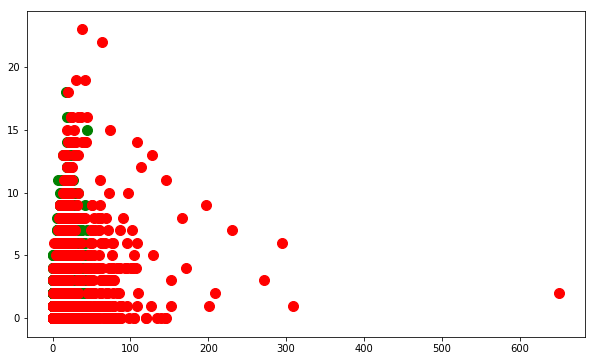

In [302]:
plt.figure(figsize=(10,6))
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'green', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'red', label = 'Iris-setosa')


##    Loans that roll forward:
        Avge Debt to burden ratio is close to 2.9
        num3mosdel_2plus on an average is 2 times more than other group
        The numebr of times they rolled back is close to 0
        Avg RPC rate is 1.40
        Avg number of paid uncure is 2 times more than otehr guys
        
    Loans that do not roll forward:
        Avge Debt to burden ratio is close to 2.8
        num3mosdel_2plus on an average is 1/2 of roll forward loans
        They rolled back atleast once
        Avg RPC rate is 2.66
        Avg number of paid uncure is 1/2 of roll forward loans
